In [2]:
import pandas as pd
import numpy as np
from collections import Counter
from ast import literal_eval

In [3]:
train = pd.read_csv('../../../../data/processed/tok_phase1_train80.csv')
validate = pd.read_csv('../../../../data/processed/tok_phase1_validate10.csv')
test = pd.read_csv('../../../../data/processed/tok_phase1_test10.csv')

In [4]:
# simplify by only working on small data set
train = train.head(9000)

In [5]:
%%time
for frame in [train, validate, test]:
    for col in ['summary_tokens', 'review_tokens']:
        frame[col] = frame[col].map(literal_eval)

CPU times: user 8.23 s, sys: 83.3 ms, total: 8.31 s
Wall time: 8.31 s


In [6]:
# social science coding random sampling code

# np.random.seed(1980)
# row_i = np.random.randint(0, high=len(df), size=20)
# for i in row_i:
#     print("Polarity: ", df.at[i, 'polarity'])
#     print("Year: ", df.at[i, 'year'])
#     print("Summary: ", df.at[i, 'summary'])
#     print()
#     print("Review: ", df.at[i, 'reviewText'])
#     print()

# Preprocessing

In [7]:
pad_mask_int = 0
pad_mask_sym = '==pad_mask=='
# padleft_int = 0
# padleft_sym = '==padleft_sym=='
# padright_int = 1
# padright_sym = '==padright_sym=='
unknown_int = 1
unknown_sym = '==unknown_sym=='

In [8]:
# vocabulary set
vocab_counter = Counter()
for doc in train['summary_tokens']:
    vocab_counter.update(doc)
for doc in train['review_tokens']:
    vocab_counter.update(doc)    

min_times_word_used = 11 # if at least 2 then the model will be prepared for unknown words in test and validation sets
print(len(vocab_counter), "tokens before discarding those that appear less than {} times.".format(min_times_word_used))
for key in list(vocab_counter.keys()):
    if vocab_counter[key] < min_times_word_used: 
        vocab_counter.pop(key)
print(len(vocab_counter), "tokens after discarding those that appear less than {} times.".format(min_times_word_used))   
vocab_set = set(vocab_counter.keys())

59852 tokens before discarding those that appear less than 11 times.
9958 tokens after discarding those that appear less than 11 times.


In [9]:
# vocabulary list and int map
vocab_list = [pad_mask_sym, unknown_sym] + sorted(vocab_set)
vocab_map = {word: index for index, word in enumerate(vocab_list)}

In [10]:
print(vocab_list[1])
vocab_map['==unknown_sym==']

==unknown_sym==


1

In [11]:
# label set
label_set = set(train['polarity'].unique())

In [12]:
# label list and int map
label_list = sorted(label_set)
label_map = {word: index for index, word in enumerate(label_list)}

In [13]:
# polarity to 0 / 1

In [14]:
from scipy import sparse 

def create_one_hot(labels, label_dict):
    """
    
    Args:
        labels:        list of labels
        label_dict:    dict of label indices
    Return:
        one_hot_numpy: sparse CSR 2d array of one-hot vectors
    """
    one_hot_numpy = sparse.dok_matrix((len(labels), len(label_dict)), dtype=np.int8)
    for i, label in enumerate(labels):
        one_hot_numpy[i, label_dict[label]] = 1
    return sparse.csr_matrix(one_hot_numpy) 

def undo_one_hot(pred, label_list):
    """
    
    Args: 
        pred: NumPy array of one-hot predicted classes
        label_list: a list of the label strings
    Return:
        label_pred: an NumPy array of predicted labels
    """
    labels = np.array(label_list)
    label_pred = labels[np.argmax(pred, axis=1)]
    return label_pred

In [15]:
y_train = create_one_hot(train['polarity'], label_map)
y_validate = create_one_hot(validate['polarity'], label_map)
y_test = create_one_hot(test['polarity'], label_map)

In [16]:
y_train.todense()

matrix([[1, 0],
        [1, 0],
        [1, 0],
        ...,
        [1, 0],
        [1, 0],
        [0, 1]], dtype=int8)

In [17]:
# replace strings with ints 
from typing import List, Set, Dict, Tuple, Optional

def word_index(los: List[List[str]], vocab_dict: Dict[str, int], unknown: int, reverse: bool=False) -> List[List[int]]:
    """
    Replaces words with integers from a vocabulary dictionary or else with 1+ number of keys in dictionary
    
    Args:
        los: list of lists of split sentences
        pad_to: how big to make the padded list
    Returns: 
        new_los: list of lists of split sentences wrapped around
        
    Examples:
    print(word_index([['one', 'two', 'three'], ['one', 'two']], {'one': 1, 'two': 2, 'three': 3}))
    """
    new_los = []
    if reverse:
        for sentence in los:
            new_los.append(reversed([vocab_dict[word] if word in vocab_dict else unknown for word in sentence]))        
    else:
        for sentence in los:
            new_los.append([vocab_dict[word] if word in vocab_dict else unknown for word in sentence])
    return new_los

In [18]:
print(word_index([['one', 'two', 'three'], ['one', 'two']], {'one': 1, 'two': 2, 'three': 3}, unknown=4))

[[1, 2, 3], [1, 2]]


In [19]:
train_summary = word_index(train['summary_tokens'], vocab_map, unknown_int)
train_review = word_index(train['review_tokens'], vocab_map, unknown_int) 

validate_summary = word_index(validate['summary_tokens'], vocab_map, unknown_int)
validate_review = word_index(validate['review_tokens'], vocab_map, unknown_int) 

test_summary = word_index(test['summary_tokens'], vocab_map, unknown_int)
test_review = word_index(test['review_tokens'], vocab_map, unknown_int) 

In [20]:
# pad / truncate 
from keras.preprocessing.sequence import pad_sequences

summary_len = max(map(len, list(train['summary_tokens'])))
review_len = 500

train_summary = pad_sequences(sequences=train_summary, 
                              maxlen=summary_len, 
                              dtype='int32', 
                              padding='pre', 
                              value=pad_mask_int)
train_review = pad_sequences(sequences=train_review, 
                             maxlen=review_len, 
                             dtype='int32', 
                             padding='pre',
                             truncating='pre',
                             value=pad_mask_int)

validate_summary = pad_sequences(sequences=validate_summary, 
                              maxlen=summary_len, 
                              dtype='int32', 
                              padding='pre', 
                              value=pad_mask_int)
validate_review = pad_sequences(sequences=validate_review, 
                             maxlen=review_len, 
                             dtype='int32', 
                             padding='pre',
                             truncating='pre',
                             value=pad_mask_int)

test_summary = pad_sequences(sequences=test_summary, 
                              maxlen=summary_len, 
                              dtype='int32', 
                              padding='pre', 
                              value=pad_mask_int)
test_review = pad_sequences(sequences=test_review, 
                             maxlen=review_len, 
                             dtype='int32', 
                             padding='pre',
                             truncating='pre',
                             value=pad_mask_int)

In [21]:
print(max(map(len, list(train['summary_tokens']))))
print(max(map(len, list(train['review_tokens']))))
print(len(vocab_list))
# could simplify this now we have a wc column

33
2740
9960


In [22]:
# one-hot if not using embeddings (a Keras embedding layer can actually also do one-hot for you so...)

# Model

In [23]:
import keras.optimizers
from keras.datasets import imdb
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Concatenate 
from keras.layers import LSTM, GRU, CuDNNGRU
from keras.layers.embeddings import Embedding
from keras.constraints import maxnorm
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

# fix random seed for reproducibility - only works for CPU version of tensorflow
np.random.seed(42)

In [25]:
import matplotlib.pyplot as plt
import sklearn.metrics
import itertools

def plot_results(losses, accuracies):
    fig,ax = plt.subplots(1,2,figsize=[12,2])
    ax[0].plot(losses)
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('iteration');
    ax[1].plot(accuracies);
    ax[1].set_ylabel('accuracy')
    ax[1].set_xlabel('iteration');
    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    From: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#        print("Normalized confusion matrix")
#    else:
#        print('Confusion matrix, without normalization')
#
#    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] != 0:
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    
def plot_confusion(y, y_pred, label_list) -> None:
    """
    Args:
        y: true labels
        y_pred: predicted labels
        label_list: ordered iterable of labels
    """
    # Compute confusion matrix
    cnf_matrix = sklearn.metrics.confusion_matrix(y, y_pred, labels=label_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plt.figure(figsize=(13,10))
    plot_confusion_matrix(cnf_matrix, classes=label_list,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plt.figure(figsize=(13,10))
    plot_confusion_matrix(cnf_matrix, classes=label_list, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [27]:
%%time
# pretrained embeddings are from https://nlp.stanford.edu/projects/glove/
# start by loading in the embedding matrix
# load the whole embedding into memory
embeddings_index = dict()
with open('../../../../data/external/glove.42B.300d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('Loaded %s word vectors.' % len(embeddings_index))

embedding_dim = 300

Loaded 1917494 word vectors.
CPU times: user 1min 38s, sys: 1.79 s, total: 1min 40s
Wall time: 1min 40s


In [28]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((len(vocab_list), embedding_dim))
count = 0
for i, word in enumerate(vocab_list):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        count += 1
        print(word)
print("Failed to find {} out of {} tokens.".format(count, len(vocab_list)))

==pad_mask==
==unknown_sym==
):
);
*
.  ...
. .
. . .
. ...
..
8/
:(
:D
:P
_possessivetag_
ba'ku
did'nt
dvd's
wouldonnell
�
Failed to find 20 out of 9960 tokens.


In [26]:
del embeddings_index

In [43]:
%%time
# Keras functional API for joined model with CuDNNGRU 
input_s = Input(shape=(summary_len,), dtype='int32', name='input_s')
input_r = Input(shape=(review_len,), dtype='int32', name='input_r')

embedding_vector_length = embedding_dim
GRU_nodes_summary = 100
GRU_nodes_review = 100

# emb_s = Embedding(len(vocab_list), embedding_vector_length, mask_zero=True,
#                   input_length=summary_len, weights=[embedding_matrix], trainable=False)(input_s)
# emb_r = Embedding(len(vocab_list), embedding_vector_length, mask_zero=True,
#                   input_length=review_len, weights=[embedding_matrix], trainable=False)(input_r)

emb = Embedding(len(vocab_list), embedding_vector_length, mask_zero=False,
                weights=[embedding_matrix], trainable=False)

emb_s = emb(input_s)
emb_r = emb(input_r)

gru_s = CuDNNGRU(GRU_nodes_summary, 
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=maxnorm(3),
    recurrent_constraint=maxnorm(3),
    bias_constraint=None,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,)(emb_s)
gru_r = CuDNNGRU(GRU_nodes_review,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=maxnorm(3),
    recurrent_constraint=maxnorm(3),
    bias_constraint=None,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,)(emb_r)

concat = Concatenate()([gru_s, gru_r])
output = Dense(len(label_set), activation='softmax')(concat)
model = Model([input_s, input_r], output)
nadam = keras.optimizers.nadam(lr=0.0006)
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])

# unfrozen embeddings
emb.trainable = True
thawn = Model([input_s, input_r], output)
thawn.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])

print(model.summary())
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
hist1 = model.fit(x=[train_summary, train_review], 
                 y=y_train, 
                 validation_data=([validate_summary, validate_review], 
                                  y_validate), 
                 epochs=50, batch_size=128, callbacks=[es])

hist2 = thawn.fit(x=[train_summary, train_review], 
                 y=y_train, 
                 validation_data=([validate_summary, validate_review], 
                                  y_validate), 
                 epochs=50, batch_size=128, callbacks=[es])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_s (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
input_r (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         multiple             2988000     input_s[0][0]                    
                                                                 input_r[0][0]                    
__________________________________________________________________________________________________
cu_dnngru_8 (CuDNNGRU)          (None, 100)          120600      embedding_6[0][0]                
__________

Training loss / accuracy


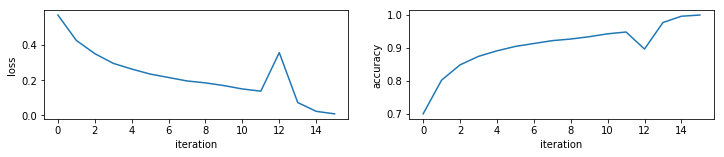

In [44]:
losses = hist1.history['loss'] + hist2.history['loss']
accuracies = hist1.history['acc'] + hist2.history['acc']
print("Training loss / accuracy")
plot_results(losses,accuracies)

Validation loss / accuracy


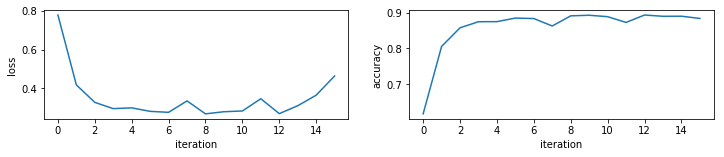

In [45]:
losses = hist1.history['val_loss'] + hist2.history['val_loss']
accuracies = hist1.history['val_acc'] + hist2.history['val_acc']
print("Validation loss / accuracy")
plot_results(losses,accuracies)

Validation data, confusion


<Figure size 432x288 with 0 Axes>

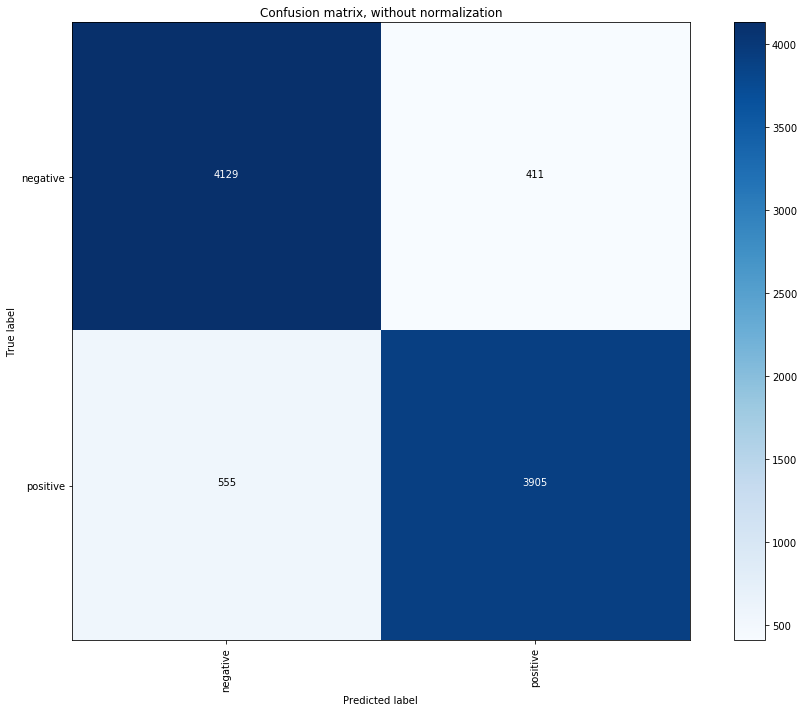

<Figure size 432x288 with 0 Axes>

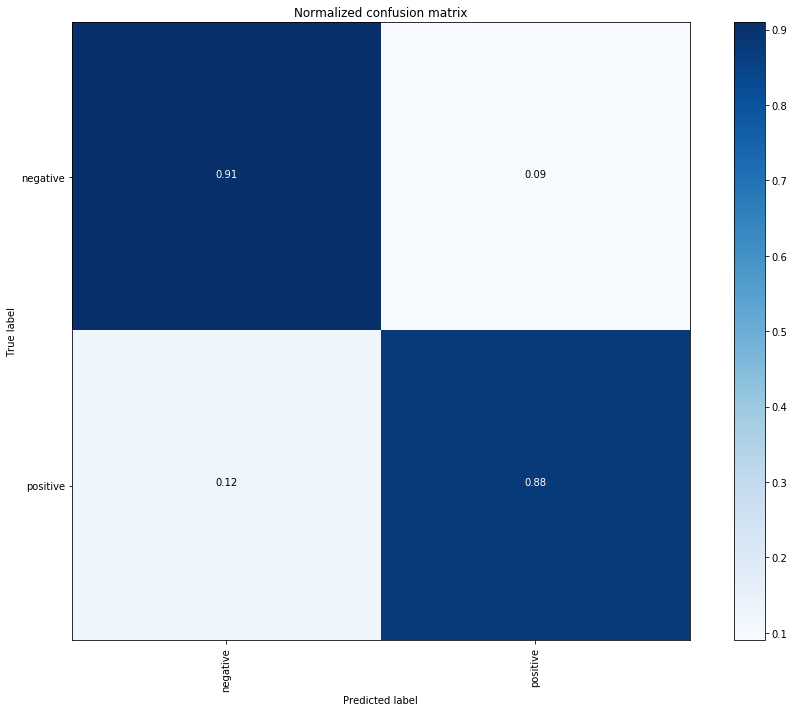

In [42]:
# Predict for validation data 
y_pred = model.predict([validate_summary, validate_review])

# Undo one-hot
y_pred = undo_one_hot(y_pred, label_list)
y_orig = validate['polarity']

print("Validation data, confusion")
plot_confusion(y_orig, y_pred, label_list)

In [31]:
%%time
# Keras functional API for joined model 
input_s = Input(shape=(summary_len,), dtype='int32', name='input_s')
input_r = Input(shape=(review_len,), dtype='int32', name='input_r')

embedding_vector_length = embedding_dim
GRU_nodes_summary = 100
GRU_nodes_review = 100

# emb_s = Embedding(len(vocab_list), embedding_vector_length, mask_zero=True,
#                   input_length=summary_len, 
#                   weights=[embedding_matrix], trainable=False)(input_s)
# emb_r = Embedding(len(vocab_list), embedding_vector_length, mask_zero=True,
#                   input_length=review_len, 
#                   weights=[embedding_matrix], trainable=False)(input_r)

emb = Embedding(len(vocab_list), embedding_vector_length, mask_zero=True,
                weights=[embedding_matrix], trainable=False)

emb_s = emb(input_s)
emb_r = emb(input_r)

gru_s = GRU(GRU_nodes_summary, activation='tanh', recurrent_activation='sigmoid', dropout=0.4, 
            recurrent_dropout=0.3, kernel_constraint=maxnorm(4), recurrent_constraint=maxnorm(5),
            unroll=True, 
            
            use_bias=True, kernel_initializer='glorot_uniform', 
            recurrent_initializer='orthogonal', bias_initializer='zeros', 
            kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None,
            activity_regularizer=None,  
            bias_constraint=None, implementation=1, return_sequences=False, return_state=False, 
            go_backwards=False, stateful=False, reset_after=False)(emb_s)
gru_r = GRU(GRU_nodes_review, activation='tanh', recurrent_activation='sigmoid', dropout=0.4, 
            recurrent_dropout=0.3, unroll=True, 
          
            kernel_constraint=None, recurrent_constraint=None,
            use_bias=True, kernel_initializer='glorot_uniform', 
            recurrent_initializer='orthogonal', bias_initializer='zeros', 
            kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, 
            activity_regularizer=None,  
            bias_constraint=None, implementation=1, return_sequences=False, return_state=False,
            go_backwards=False, stateful=False, reset_after=False)(emb_r)


concat = Concatenate()([gru_s, gru_r])
output = Dense(len(label_set), activation='softmax')(concat)
model = Model([input_s, input_r], output)
nadam = keras.optimizers.nadam(lr=0.0006)
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])

# unfrozen embeddings
emb.trainable = True
thawn = Model([input_s, input_r], output)
thawn.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])

print(model.summary())
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
hist1 = model.fit(x=[train_summary, train_review], 
                 y=y_train, 
                 validation_data=([validate_summary, validate_review], 
                                  y_validate), 
                 epochs=50, batch_size=128, callbacks=[es])

hist2 = thawn.fit(x=[train_summary, train_review], 
                 y=y_train, 
                 validation_data=([validate_summary, validate_review], 
                                  y_validate), 
                 epochs=50, batch_size=128, callbacks=[es])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_s (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
input_r (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         multiple             2988000     input_s[0][0]                    
                                                                 input_r[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 100)          120300      embedding_3[0][0]                
__________

Training loss / accuracy


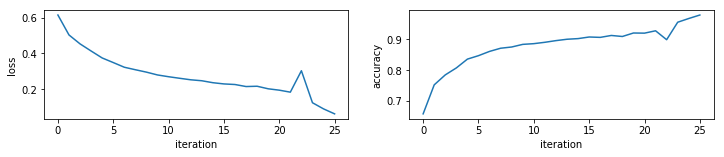

In [32]:
losses = hist1.history['loss'] + hist2.history['loss']
accuracies = hist1.history['acc'] + hist2.history['acc']
print("Training loss / accuracy")
plot_results(losses,accuracies)

Validation loss / accuracy


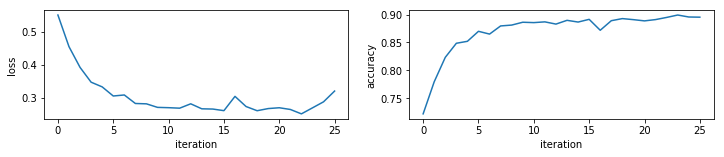

In [33]:
losses = hist1.history['val_loss'] + hist2.history['val_loss']
accuracies = hist1.history['val_acc'] + hist2.history['val_acc']
print("Validation loss / accuracy")
plot_results(losses,accuracies)

Validation data, confusion


<Figure size 432x288 with 0 Axes>

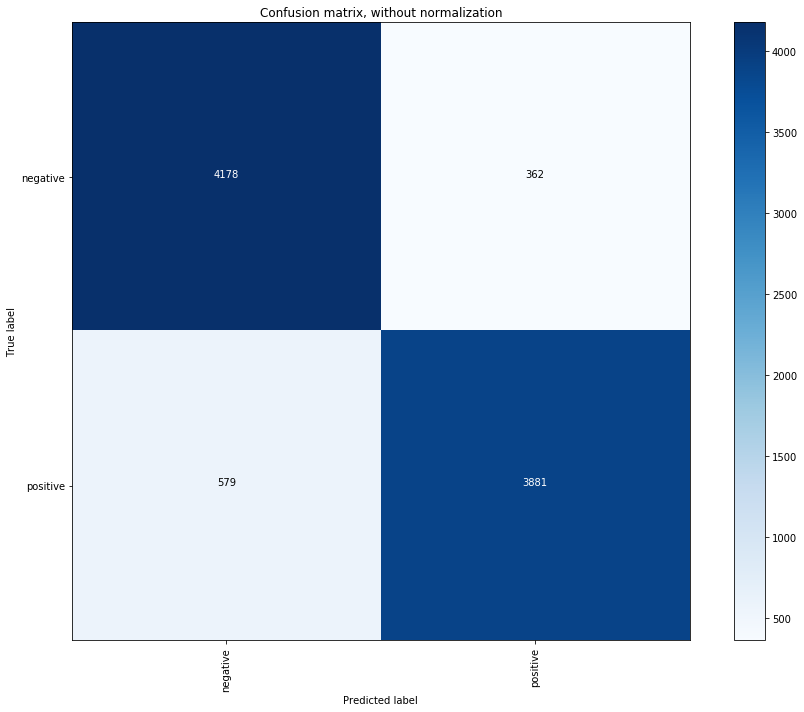

<Figure size 432x288 with 0 Axes>

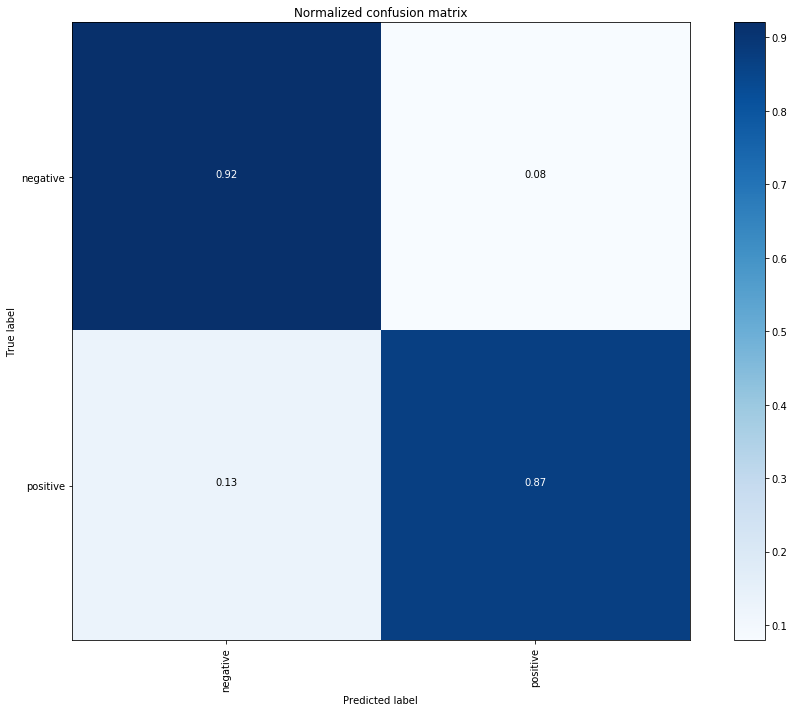

In [34]:
# Predict for validation data 
y_pred = model.predict([validate_summary, validate_review])

# Undo one-hot
y_pred = undo_one_hot(y_pred, label_list)
y_orig = validate['polarity']

print("Validation data, confusion")
plot_confusion(y_orig, y_pred, label_list)

In [ ]:
%%time
# Keras functional API for joined model w/ metadata
input_s = Input(shape=(summary_len,), dtype='int32', name='input_s')
input_r = Input(shape=(review_len,), dtype='int32', name='input_r')
input_wc_s = Input(shape=(1,), dtype='float32', name='input_wc_s')
input_wc_r = Input(shape=(1,), dtype='float32', name='input_wc_r')
input_year = Input(shape=(1,), dtype='float32', name='input_year')

embedding_vector_length = embedding_dim
GRU_nodes_summary = 100
GRU_nodes_review = 100

emb_s = Embedding(len(vocab_list), embedding_vector_length, mask_zero=True,
                  input_length=summary_len, weights=[embedding_matrix], trainable=False)(input_s)
emb_r = Embedding(len(vocab_list), embedding_vector_length, mask_zero=True,
                  input_length=review_len, weights=[embedding_matrix], trainable=False)(input_r)

gru_s = GRU(GRU_nodes_summary, activation='relu', recurrent_activation='sigmoid', dropout=0.3, 
              recurrent_dropout=0.3, kernel_constraint=maxnorm(4), recurrent_constraint=maxnorm(5),
              unroll=True, 
            
              use_bias=True, kernel_initializer='glorot_uniform', 
              recurrent_initializer='orthogonal', bias_initializer='zeros', 
              kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, 
              activity_regularizer=None,  
              bias_constraint=None, implementation=1, return_sequences=False, return_state=False, 
              go_backwards=False, stateful=False, reset_after=False)(emb_s)
gru_r = GRU(GRU_nodes_review, activation='relu', recurrent_activation='sigmoid', dropout=0.3, 
              recurrent_dropout=0.3, unroll=True, 
              
              kernel_constraint=None, recurrent_constraint=None,
              use_bias=True, kernel_initializer='glorot_uniform', 
              recurrent_initializer='orthogonal', bias_initializer='zeros', 
              kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, 
              activity_regularizer=None,  
              bias_constraint=None, implementation=1, return_sequences=False, return_state=False, 
              go_backwards=False, stateful=False, reset_after=False)(emb_r)

concat1 = Concatenate()([input_wc_s, input_wc_r, input_year])
calc = Dense(32, activation='relu')(concat1) 

concat2 = Concatenate()([gru_s, gru_r, calc])

output = Dense(len(label_set), activation='softmax')(concat2)
model = Model([input_s, input_r, input_wc_s, input_wc_r, input_year], output)
nadam = keras.optimizers.nadam(lr=0.0006)
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
print(model.summary())
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
hist = model.fit(x=[train_summary, train_review, train['summary_wc'], train['review_wc'], train['year']], 
                 y=y_train, 
                 validation_data=([validation_summary, validation_review, 
                                   validation['summary_wc'], validation['review_wc'],
                                   validation['year']], 
                                  y_validation), 
                 epochs=50, batch_size=128, callbacks=[es])

In [ ]:
losses=hist.history['loss']
accuracies=hist.history['acc']
print("Training loss / accuracy")
plot_results(losses,accuracies)

In [ ]:
losses=hist.history['val_loss']
accuracies=hist.history['val_acc']
print("Validation loss / accuracy")
plot_results(losses,accuracies)

In [ ]:
# Predict for validation data 
y_pred = model.predict([validation_summary, validation_review, 
                        validation['summary_wc'], validation['review_wc'],
                        validation['year']])

# Undo one-hot
y_pred = undo_one_hot(y_pred, label_list)
y_orig = validation['polarity']

print("Validation data, confusion")
plot_confusion(y_orig, y_pred, label_list)

In [ ]:
for weight in model.get_weights():
    df = pd.DataFrame(weight)
    print(df[df.isnull().any(axis=1)])

In [ ]:
# remove embeddings by removing "weights=[embedding_matrix]" from Keras code

In [ ]:
%%time
# create and run the model (with summaries)
embedding_vector_length = embedding_dim
model = Sequential()
model.add(Embedding(len(vocab_list), embedding_vector_length, mask_zero=True,
                    input_length=summary_len, weights=[embedding_matrix], trainable=False))
model.add(GRU(100, activation='relu', recurrent_activation='sigmoid', dropout=0.3, 
              recurrent_dropout=0.3, kernel_constraint=maxnorm(4), recurrent_constraint=maxnorm(5),

              use_bias=True, kernel_initializer='glorot_uniform', 
              recurrent_initializer='orthogonal', bias_initializer='zeros', 
              kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, 
              activity_regularizer=None,  
              bias_constraint=None, implementation=1, return_sequences=False, return_state=False, 
              go_backwards=False, stateful=False, unroll=True, reset_after=False))
model.add(Dense(len(label_set), activation='softmax'))
nadam = keras.optimizers.nadam(lr=0.0006)
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
print(model.summary())
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
hist = model.fit(x=train_summary, y=y_train, 
                 validation_data=(validation_summary, y_validation), 
                 epochs=50, batch_size=128, callbacks=[es])

In [ ]:
losses=hist.history['loss']
accuracies=hist.history['acc']
print("Training loss / accuracy")
plot_results(losses,accuracies)

In [ ]:
losses=hist.history['val_loss']
accuracies=hist.history['val_acc']
print("Validation loss / accuracy")
plot_results(losses,accuracies)

In [ ]:
# Predict for validation data 
y_pred = model.predict(validation_summary)

# Undo one-hot
y_pred = undo_one_hot(y_pred, label_list)
y_orig = validation['polarity']

print("Validation data, confusion")
plot_confusion(y_orig, y_pred, label_list)

In [ ]:
for weight in model.get_weights():
    df = pd.DataFrame(weight)
    print(df[df.isnull().any(axis=1)])

In [ ]:
%%time
# create and run the model (with reviews)
embedding_vector_length = embedding_dim
model = Sequential()
model.add(Embedding(len(vocab_list), embedding_vector_length, mask_zero=True,
                    input_length=review_len, weights=[embedding_matrix], trainable=False))
model.add(GRU(100, activation='relu', recurrent_activation='sigmoid', dropout=0.3, 
              recurrent_dropout=0.3, 
              
              kernel_constraint=None, recurrent_constraint=None,
              use_bias=True, kernel_initializer='glorot_uniform', 
              recurrent_initializer='orthogonal', bias_initializer='zeros', 
              kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, 
              activity_regularizer=None,  
              bias_constraint=None, implementation=1, return_sequences=False, return_state=False, 
              go_backwards=False, stateful=False, unroll=True, reset_after=False))
model.add(Dense(len(label_set), activation='softmax'))
nadam = keras.optimizers.nadam(lr=0.0006, clipvalue=0.5)
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
print(model.summary())
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
hist = model.fit(x=train_review, y=y_train, 
                 validation_data=(validation_review, y_validation), 
                 epochs=50, batch_size=128, callbacks=[es])

In [ ]:
losses=hist.history['loss']
accuracies=hist.history['acc']
print("Training loss / accuracy")
plot_results(losses,accuracies)

In [ ]:
losses=hist.history['val_loss']
accuracies=hist.history['val_acc']
print("Validation loss / accuracy")
plot_results(losses,accuracies)

In [ ]:
for weight in model.get_weights():
    df = pd.DataFrame(weight)
    print(df[df.isnull().any(axis=1)])

In [ ]:
# Predict for validation data 
y_pred = model.predict(validation_review)

# Undo one-hot
y_pred = undo_one_hot(y_pred, label_list)
y_orig = validation['polarity']

print("Validation data, confusion")
plot_confusion(y_orig, y_pred, label_list)